Still trying to figure out various ways of separating buildings from each other, but in the meantime, can we improve the raw segmentation results with better loss functions?

Some examples are 
- Lovasz-Softmax Loss
- Dice coefficient (variant of jaccard loss)
- Binary cross entropy (since background class is much more dominant)

or better image augmentations
- e.g mixup, cutout etc

or weighted edges

or Test time augmentation


In [1]:
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import tifffile as tiff
from skimage.external import tifffile as sktif
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

In [2]:
from lovasz_losses import *

In [3]:
data_dir = Path("/media/wwymak/Storage/urban-3D-satellite")
train_dir = data_dir / "training"
cropped_dir =  data_dir / "cropped_training"
cropped_val_dir =  data_dir / "cropped_validation"

def get_img_id(fname):
    fname = fname.replace('_RGB.tif', '')
    img_id = "_".join(fname.split('_')[:-1])
    return img_id

train_img_ids = [get_img_id(f.name) for f in cropped_dir.ls() if f.name.endswith('RGB.tif')]
val_img_ids = [get_img_id(f.name) for f in cropped_val_dir.ls() if f.name.endswith('RGB.tif')]

In [4]:
train_cropped_imgs = [f.name for f in (data_dir / "cropped_training").ls() if f.name.endswith('RGB.tif')]
valid_cropped_imgs = [f.name for f in (data_dir / "cropped_validation").ls() if f.name.endswith('RGB.tif')]

dataset_df = pd.DataFrame({"name":[f"cropped_training/{f}" for f in train_cropped_imgs]  \
   + [f"cropped_validation/{f}" for f in valid_cropped_imgs],
   "label": [f"{str(data_dir)}/cropped_training/{f.replace('RGB', 'pytorch_GTL')}" for f in train_cropped_imgs]  \
   + [f"{str(data_dir)}/cropped_validation/{f.replace('RGB', 'pytorch_GTL')}" for f in valid_cropped_imgs],\
        "is_valid":   [False for i in train_cropped_imgs] + [True for i in valid_cropped_imgs ]   })

In [5]:
# codes = ["building"]
codes = ["background", "building"]
src = (SegmentationItemList.from_df(dataset_df, path=data_dir )
      . split_from_df(col="is_valid")
       .label_from_df(cols="label", classes=codes))

In [6]:
size = 128
bs=64
data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [6]:
def accuracy_pixel(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()


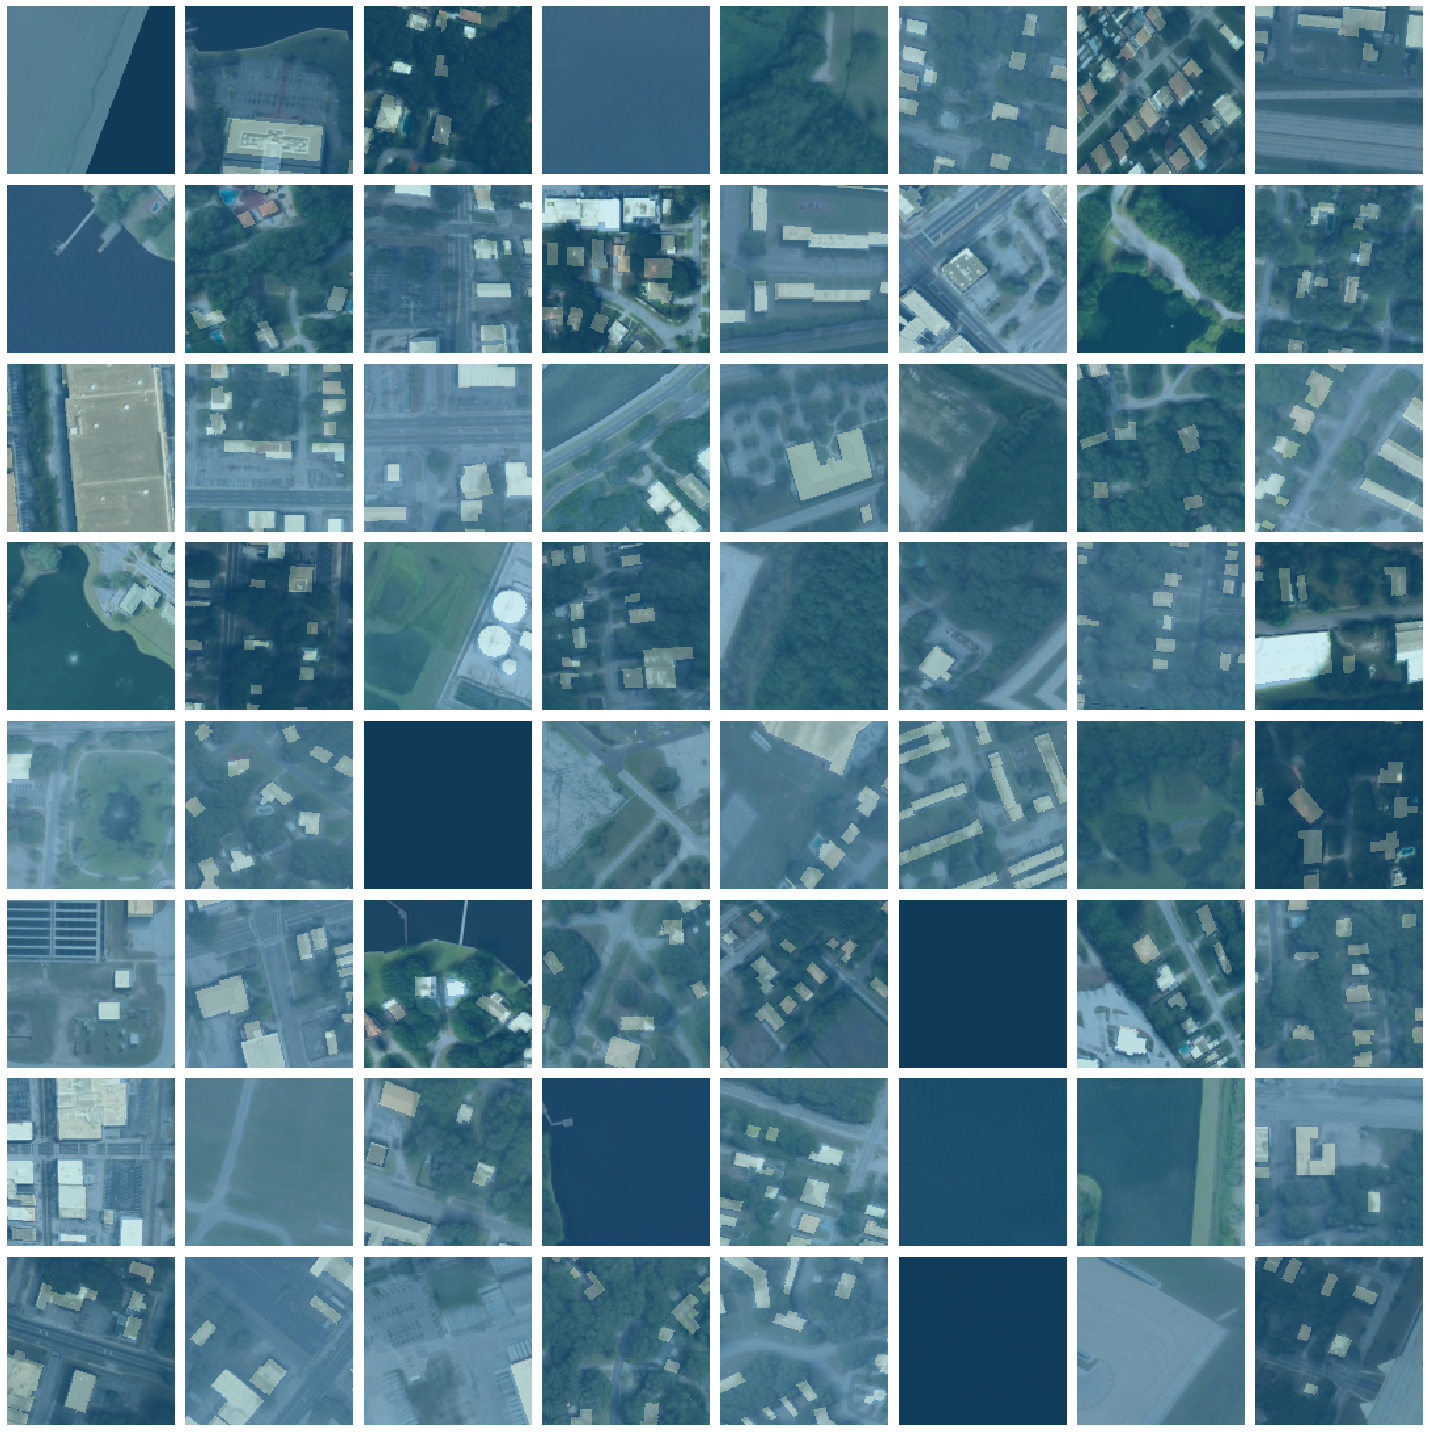

In [11]:
data.show_batch(8, figsize=(20,20))

In [7]:
def flatten_binary_scores2(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.contiguous().view(-1)
    labels = labels.contiguous().view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels
def lovasz_hinge(logits, labels, per_image=False, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    print(logits.min(), logits.max(), logits.size())
    logits=logits[:,1,:,:]
    labels = labels.squeeze(1)
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores2(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(torch.nn.functional.relu(errors_sorted), Variable(grad))
    return loss


def combined_loss(logits, labels):
    logits=logits[:,1,:,:].float()
    labels = labels.squeeze(1).float()
    
    lh_loss = lovasz_hinge_flat(*flatten_binary_scores2(logits, labels, ignore=0))
    bce_loss = F.binary_cross_entropy_with_logits(logits, labels)
    
    return 0.8 * bce_loss + lh_loss

In [23]:
wd =1e-2
metrics = [accuracy_pixel,dice]
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, loss_func=combined_loss)
learn.to_fp16();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


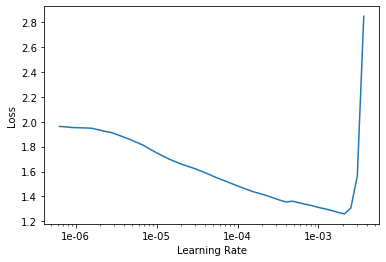

In [24]:
lr_find(learn)
learn.recorder.plot(skip_end=1)

In [25]:
lr=1e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_pixel,dice,time
0,0.941657,0.723196,0.981836,0.259024,00:15
1,0.781955,0.605283,0.973925,0.317851,00:09
2,0.720370,0.587200,0.986201,0.318457,00:09
3,0.633609,0.454838,0.973237,0.386033,00:09
4,0.591445,0.451638,0.945282,0.366780,00:09
5,0.613031,0.556444,0.983696,0.322247,00:09
6,0.647956,0.538623,0.970270,0.360594,00:09
7,0.599904,0.536134,0.990787,0.337628,00:09
8,0.556940,0.413740,0.986343,0.421020,00:09
9,0.502675,0.389141,0.981200,0.452987,00:09


In [26]:
learn.save('lovaz-loss-stage1')

the loss combined with lovasz_hinge seems to have helped!

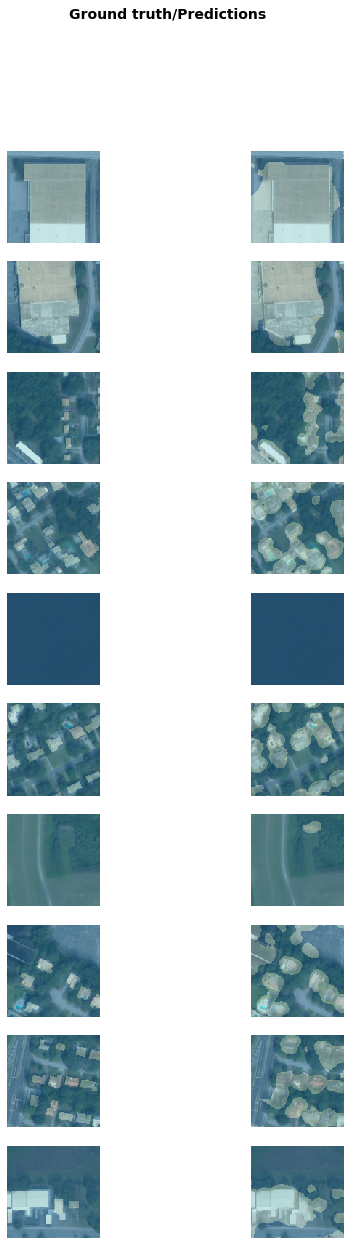

In [27]:
learn.show_results(rows=10, figsize=(8,20))

However, as we can see, there are issues with the buildings merging into each other, probably as we're not handling the class 0 loss very well.

What if, we update the combined loss to not ignore the zeros?

In [22]:
def combined_loss2(logits, labels):
    logits=logits[:,1,:,:].float()
    labels = labels.squeeze(1).float()
    
    lh_loss = lovasz_hinge_flat(*flatten_binary_scores2(logits, labels))
    bce_loss = F.binary_cross_entropy_with_logits(logits, labels)
    
    return 0.8 * bce_loss + lh_loss

In [10]:
wd =1e-2
metrics = [accuracy_pixel,dice]
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, loss_func=combined_loss2)
learn.to_fp16();

In [11]:
lr=1e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_pixel,dice,time
0,2.096585,1.625379,0.291321,0.294147,00:14
1,1.729736,1.373122,0.039301,0.072654,00:09
2,1.572195,1.342182,0.088764,0.157758,00:09
3,1.467142,1.363441,0.041958,0.079739,00:09
4,1.460650,1.297386,0.266683,0.389975,00:09
5,1.410257,1.249807,0.374496,0.496982,00:09
6,1.342018,1.139163,0.480276,0.602772,00:09
7,1.312162,1.133835,0.499022,0.622152,00:09
8,1.282838,1.083839,0.581498,0.668909,00:09
9,1.229516,1.086541,0.604295,0.678851,00:09


In [12]:
learn.save('lovaz-loss-stage1-ignore-none')

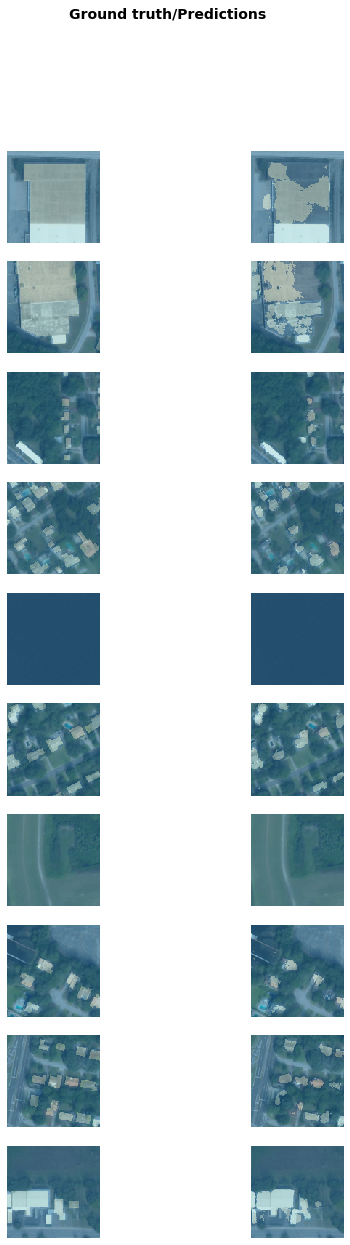

In [13]:
learn.show_results(rows=10, figsize=(8,20))

In [14]:
learn.unfreeze()
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


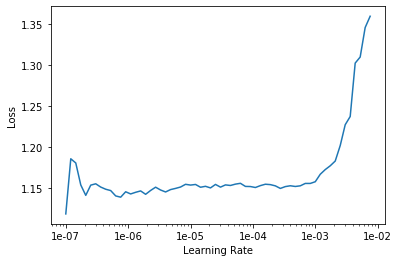

In [18]:
learn.recorder.plot(skip_start=None)

In [19]:
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_pixel,dice,time
0,1.159289,1.072842,0.594632,0.677623,00:10
1,1.148537,1.065870,0.603912,0.683072,00:10
2,1.145095,1.068238,0.619173,0.688815,00:09
3,1.135726,1.054417,0.627061,0.696300,00:09
4,1.123820,1.043263,0.622098,0.693442,00:10
5,1.111574,1.032858,0.667092,0.710604,00:10
6,1.109143,1.035043,0.630003,0.705366,00:09
7,1.099070,1.031720,0.701172,0.723736,00:09
8,1.088027,0.998545,0.656065,0.717367,00:10
9,1.072874,1.011678,0.663764,0.718923,00:09


In [20]:
learn.save('lovaz-loss-stage2-ignore-none')

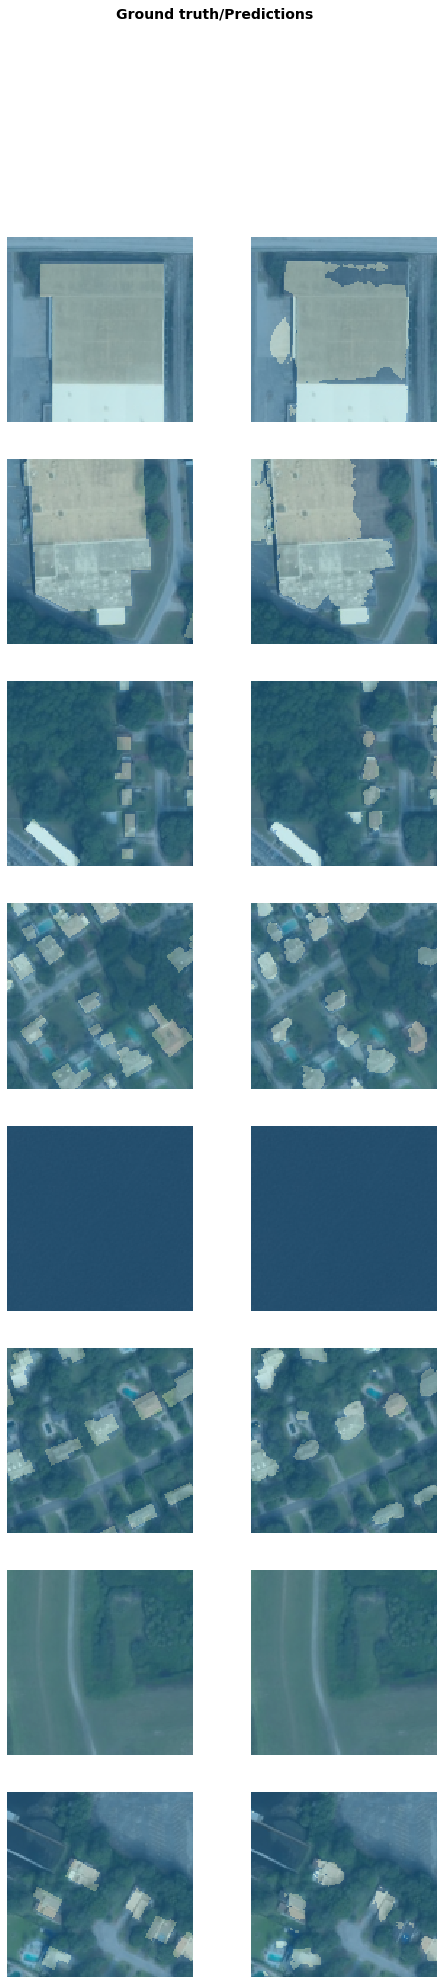

In [22]:
learn.show_results(rows=8)

In [8]:
# increase image sizes and continue training
wd =1e-2
metrics = [accuracy_pixel,dice]

size = 256
bs=32
data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))



In [23]:
try:
    learn.data = data
except:
    
    learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, loss_func=combined_loss2)
    learn.to_fp16();
    
learn.load('lovaz-loss-stage2-ignore-none')

learn.freeze()
learn.to_fp16();
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


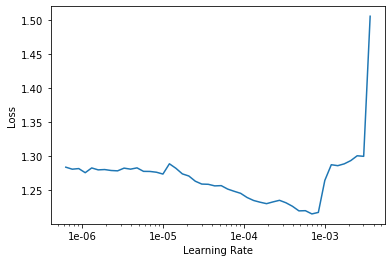

In [24]:
learn.recorder.plot(skip_end=1)

In [25]:
lr=1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.8, 
        callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='lovaz-loss-stage3-ignore-none')])

epoch,train_loss,valid_loss,accuracy_pixel,dice,time
0,1.171193,1.139302,0.744372,0.723440,00:33
1,1.121718,1.190995,0.745211,0.741132,00:33
2,1.109659,1.046413,0.778693,0.748786,00:32
3,1.071222,0.994989,0.770700,0.758337,00:33
4,1.043691,0.924012,0.742449,0.764929,00:33
5,1.031354,0.917510,0.756440,0.768916,00:33
6,1.012524,0.916214,0.773177,0.772853,00:33
7,1.010209,0.911846,0.785267,0.774773,00:32
8,0.988066,0.908342,0.808190,0.774416,00:33
9,0.959390,0.884320,0.791626,0.780417,00:35


Better model found at epoch 0 with dice value: 0.7234397530555725.
Better model found at epoch 1 with dice value: 0.7411317229270935.
Better model found at epoch 2 with dice value: 0.7487855553627014.
Better model found at epoch 3 with dice value: 0.758337140083313.
Better model found at epoch 4 with dice value: 0.7649291753768921.
Better model found at epoch 5 with dice value: 0.768915593624115.
Better model found at epoch 6 with dice value: 0.772853434085846.
Better model found at epoch 7 with dice value: 0.7747730016708374.
Better model found at epoch 9 with dice value: 0.7804170250892639.


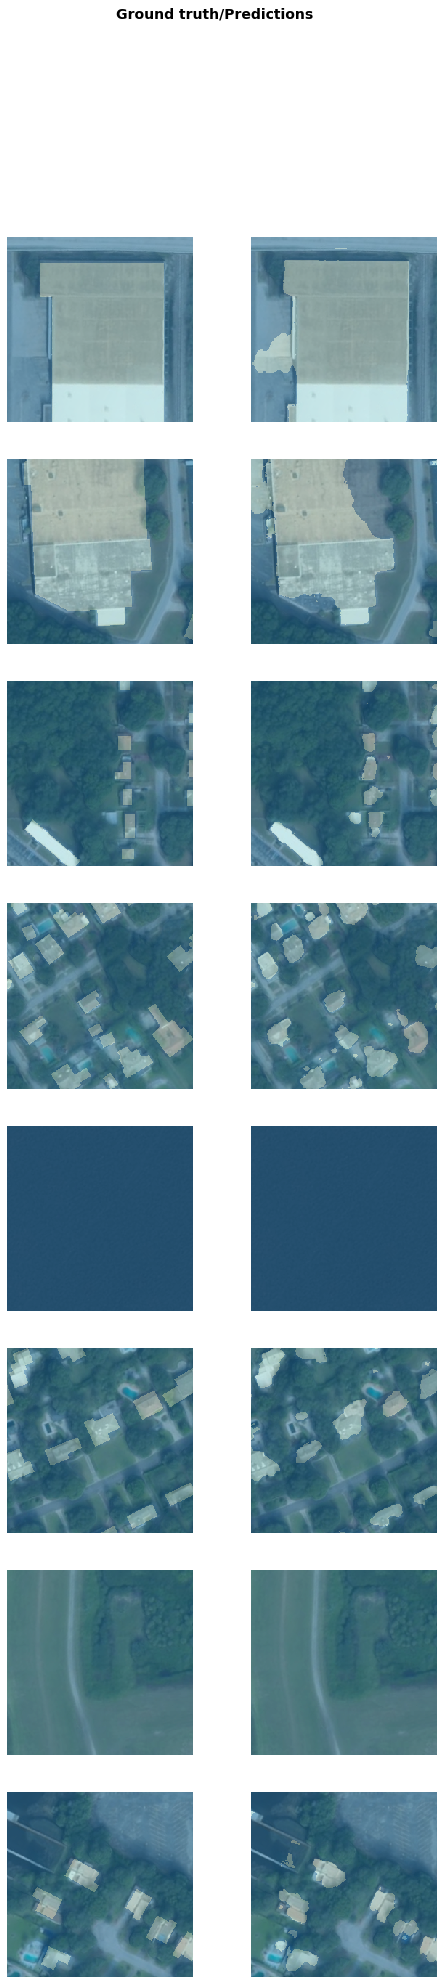

In [26]:
learn.show_results(rows=8)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


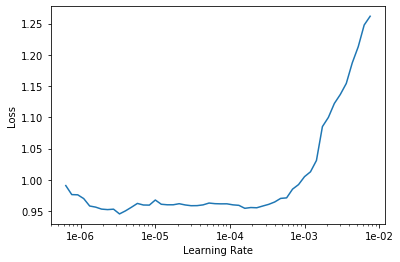

In [27]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(12, lrs, pct_start=0.8, 
        callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='lovaz-loss-stage4-ignore-none')])

epoch,train_loss,valid_loss,accuracy_pixel,dice,time


smaller batch sizes?

In [29]:
F.cross_entropy??